In [239]:
# miscellaneous
import matplotlib.pyplot as plt

from glob import glob #library that helps us search for files
import scipy
import random
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from scipy.special import inv_boxcox
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# hyperparameter tuning
from hyperopt import hp
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials, partial

# preprocessing
from category_encoders import OneHotEncoder,TargetEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer,LabelEncoder, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,cross_val_predict, KFold, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer,LabelEncoder, MaxAbsScaler, RobustScaler

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,BayesianRidge, ElasticNet, Lasso
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
import lightgbm as lgb

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import log_loss, confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils.validation import check_is_fitted

# feature selection / data sampling
from sklearn.feature_selection import RFE, SelectKBest, f_classif, SelectFromModel, VarianceThreshold
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance

# saving model
import pickle,joblib
import boto3

# data settings
pd.pandas.set_option('display.max_rows',None)
pd.pandas.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)


from sklearn import set_config
set_config(transform_output = 'pandas')

import warnings
warnings.simplefilter(action="ignore")


import json

# custom package
import importlib
import package
importlib.reload(package)

from package.data_retrieval.data_retrieval import s3_retrieval, write_to_s3
from package.eda.data_exploration import correlation
from package.training.model_training import model_evaluation, split_data_by_type, performance_plots
from package.preprocessing.data_preprocessing import create_pipeline, winsorize, percentile_imputer, random_sample_imputer, count_encoder 

# Read Config

In [3]:
config_path = "C:/Users/Oamen/OneDrive/Documents/DATA PROJECTS/Insurance_claim_prediction_porto/config.json"

In [13]:
# Opening JSON file
with open(config_path) as file:
    
    config = json.load(file)

# Read Data

In [15]:
# get access key
secret = pd.read_csv("C:/Users/Oamen/Downloads/jupyter_iam_accessKeys.csv")

In [16]:
# create S3 client object 
s3_client = boto3.client('s3',aws_access_key_id=secret['Access key ID'][0],aws_secret_access_key=secret['Secret access key'][0])

In [17]:
bucket_name = config['EDA']['bucket_name'] 

In [18]:
# retrieve data
full_train_df = s3_retrieval(s3_client, bucket_name, config['Model_Selection']['Input_data']['full_train'])

Retrieved object
Read bytes
Success!


In [19]:
#reduced_train_df = s3_retrieval(s3_client, bucket_name, reduced_train_new_key)

In [20]:
validation_df = s3_retrieval(s3_client, bucket_name, config['Model_Selection']['Input_data']['validation'])

Retrieved object
Read bytes
Success!


In [21]:
test_df = s3_retrieval(s3_client, bucket_name, config['Model_Selection']['Input_data']['test'])

Retrieved object
Read bytes
Success!


# Training Preprocessor

## Preprocessor - Experiment 1

1. Missing Values: Simple
2. Encoding: One-Hot
3. Transformation: Log
4. Outliers: Winsorize(0.95-0.05)
5. Scaling: StandardScaler
6. Resampling: SMOTE
7. Feature Selection: Enet Coefs

In [81]:
categorical_exp1, numerical_exp1, xtrain_exp1, ytrain_exp1 = split_data_by_type(full_train_df, config['EDA']['target'])

In [82]:
categorical_exp1, numerical_exp1, xvalidation_exp1, yvalidation_exp1 = split_data_by_type(validation_df, config['EDA']['target'])

In [83]:
num_pipeline_exp1 = Pipeline([
    ('transformer', FunctionTransformer(np.log1p)),
    ('imputer', SimpleImputer(strategy = 'median')),
    ('winsorize', FunctionTransformer(winsorize)),
    ('scaler', StandardScaler()),  
])

cat_pipeline_exp1 = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder()),
    
])

In [84]:
pipeline_exp1 = create_pipeline(num_pipeline_exp1, numerical_exp1, cat_pipeline_exp1, categorical_exp1)

In [85]:
xtrain_exp1 = pipeline_exp1.fit_transform(xtrain_exp1)

In [86]:
xvalidation_exp1 = pipeline_exp1.transform(xvalidation_exp1)

In [87]:
# smote

smote = SMOTE()

In [88]:
xtrain_exp1, ytrain_exp1 = smote.fit_resample(xtrain_exp1, ytrain_exp1)

In [89]:
# feature selection - Enet Coefs

enet = ElasticNet(l1_ratio = 0.5, alpha = 0.01)

enet.fit(xtrain_exp1, ytrain_exp1)

ElasticNet(alpha=0.01)

In [90]:
imp_columns1 = dict(zip(xtrain_exp1.columns, enet.coef_))

In [91]:
selected_columns_exp1 = [column for column, value in imp_columns1.items() if abs(value) > 0]

len(selected_columns_exp1)

31

In [92]:
xtrain_exp1 = xtrain_exp1[selected_columns_exp1]

xvalidation_exp1 = xvalidation_exp1[selected_columns_exp1]

### Hyperparameter Tuning - Exp 1

#### Random Forest

In [117]:
# create the search space for an over fitting model

search_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.quniform('max_depth', 2, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 4, 30, 1),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes',8,30,1),
    'warm_start': hp.choice('warm_start', [True, False]),
    'class_weight': hp.choice('class_weight', ['balanced', 'balanced_subsample']),
    'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.9)
   
}

In [118]:
def objective(params, n_folds, x, y):
    
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    

    model = RandomForestClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [119]:
# optimize with the TPE algorithm
trials_0 = Trials()
n_folds = 4

best = fmin(fn = partial(objective, n_folds = n_folds,
                         x = xtrain_exp1, y = ytrain_exp1),
           space = search_space, algo = tpe.suggest, max_evals = 8, trials = trials_0,
           )

100%|█████████████████████████████████████████████| 8/8 [2:51:41<00:00, 1287.64s/trial, best loss: 0.33333150993660055]


In [120]:
print(best)

{'ccp_alpha': 0.8355154331803291, 'class_weight': 0, 'criterion': 1, 'max_depth': 25.0, 'max_leaf_nodes': 10.0, 'min_samples_split': 16.0, 'min_weight_fraction_leaf': 0.03164012540078487, 'n_estimators': 251.0, 'warm_start': 0}


In [121]:
print(trials_0.best_trial['result']['loss'])

0.33333150993660055


#### LightGBM

In [122]:
search_space = {
    'num_leaves': hp.quniform('num_leaves', 2,31,1),
    'max_depth': hp.quniform('max_depth', 2,31,1),
    'n_estimators': hp.quniform('n_estimators', 2,100,1),
    'min_child_samples': hp.quniform('min_child_samples', 20,100,1),
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 0.9),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.9),    
}

In [123]:
def objective(params, n_folds, x, y):
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_samples'] = int(params['min_child_samples'])
    
    
    
    model = lgb.LGBMClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [124]:
# optimize with the TPE algorithm
trials_1 = Trials()
n_folds = 4

best = fmin(fn = partial(objective, n_folds = n_folds,
                         x = xtrain_exp1, y = ytrain_exp1),
           space = search_space, algo = tpe.suggest, max_evals = 8, trials = trials_1,
           )

[LightGBM] [Info] Number of positive: 365618, number of negative: 365617                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151327 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7678                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 31                          
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003                                         
[LightGBM] [Info] Start training from score 0.000003                                                                   
[LightGBM] [Info] Number of positive: 365618, number of negative: 365617                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171815 seconds

[LightGBM] [Info] Total Bins 7679                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 31                          
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000003                                        
[LightGBM] [Info] Start training from score -0.000003                                                                  
[LightGBM] [Info] Number of positive: 365617, number of negative: 365618                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156238 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7678                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 31         

[LightGBM] [Info] Start training from score 0.000003                                                                   
[LightGBM] [Info] Number of positive: 365618, number of negative: 365617                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169419 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7679                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 31                          
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003                                         
[LightGBM] [Info] Start training from score 0.000003                                                                   
[LightGBM] [Info] Number of positive: 365617, number of negative: 365618                              

[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 31                          
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000003                                        
[LightGBM] [Info] Start training from score -0.000003                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

In [125]:
print(best)

{'max_depth': 13.0, 'min_child_samples': 45.0, 'n_estimators': 82.0, 'num_leaves': 28.0, 'reg_alpha': 0.8485727275388625, 'reg_lambda': 0.25697353165485826}


In [126]:
print(trials_1.best_trial['result']['loss'])

1.64107950209047e-05


#### Xgboost

In [267]:
search_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 10, 1),
}

In [268]:
def objective(params, n_folds, x, y):
    
    params['scale_pos_weight'] = int(params['scale_pos_weight'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    
    model = xgb.XGBClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [ ]:
#  optimize with the TPE algorithm
trials_x = Trials()
n_folds = 4

best = fmin(fn = partial(objective, n_folds = n_folds,
                         x = xtrain_exp1, y = ytrain_exp1),
           space = search_space, algo = tpe.suggest, max_evals = 8, trials = trials_x,
           )

 25%|██████████                              | 2/8 [3:51:43<10:22:02, 6220.38s/trial, best loss: 7.384251852216028e-05]

In [ ]:
print(best)

In [ ]:
print(trials_x.best_trial['result']['loss'])

## Preprocessor - Experiment 2

1. Missing Values: Percentile Imputation
2. Encoding: Ordinal
3. Transformation: Sqrt
4. Outliers: Winsorize(0.95-0.05)
5. Scaling: RobustScaler
6. Resampling: ADASYN
7. Feature Selection: SelectFromModel

In [127]:
categorical_exp2, numerical_exp2, xtrain_exp2, ytrain_exp2 = split_data_by_type(full_train_df, config['EDA']['target'])

categorical_exp2, numerical_exp2, xvalidation_exp2, yvalidation_exp2 = split_data_by_type(validation_df, config['EDA']['target'])

In [128]:
num_pipeline_exp2 = Pipeline([
    ('transformer', FunctionTransformer(np.sqrt)),
    ('imputer', FunctionTransformer(percentile_imputer)),
    ('winsorize', FunctionTransformer(winsorize)),
    ('scaler', RobustScaler()),  
])

cat_pipeline_exp2 = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OrdinalEncoder()),
    
])

In [129]:
pipeline_exp2 = create_pipeline(num_pipeline_exp2, numerical_exp2, cat_pipeline_exp2, categorical_exp2)

In [130]:
xtrain_exp2 = pipeline_exp2.fit_transform(xtrain_exp2)

In [131]:
xvalidation_exp2 = pipeline_exp2.transform(xvalidation_exp2)

In [132]:
# adasyn

adasyn = ADASYN()

In [133]:
xtrain_exp2, ytrain_exp2 = adasyn.fit_resample(xtrain_exp2, ytrain_exp2)

In [134]:
rf = RandomForestClassifier()

selector = SelectFromModel(rf, threshold=0.0001).fit(xtrain_exp2, ytrain_exp2)

In [135]:
selected_columns_exp2 = xtrain_exp2.columns[selector.get_support()]

len(selected_columns_exp2)

51

In [136]:
xtrain_exp2 = xtrain_exp2[selected_columns_exp2]

xvalidation_exp2 = xvalidation_exp2[selected_columns_exp2]

### Hyperparameter Tuning - Exp 2

#### Random Forest

In [137]:
# create the search space for an over fitting model

search_space = {
    'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.quniform('max_depth', 2, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 4, 30, 1),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes',8,30,1),
    'warm_start': hp.choice('warm_start', [True, False]),
    'class_weight': hp.choice('class_weight', ['balanced', 'balanced_subsample']),
    'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.9)
   
}

In [138]:
def objective(params, n_folds, x, y):
    
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    
    
    model = RandomForestClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [139]:
def objective(params, n_folds, x, y):
    
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    
    
    model = RandomForestClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [142]:
# optimize with the TPE algorithm
trials_2 = Trials()
n_folds = 4

best = fmin(fn = partial(objective, n_folds = n_folds,
                         x = xtrain_exp2, y = ytrain_exp2),
           space = search_space, algo = tpe.suggest, max_evals = 8, trials = trials_2,
           )

100%|█████████████████████████████████████████████| 8/8 [2:45:19<00:00, 1239.96s/trial, best loss: 0.20725583525524638]


In [143]:
print(trials_2.best_trial['result']['loss'])

0.20725583525524638


In [226]:
config['Hyperparameter Tuning'] = {}
config['Hyperparameter Tuning']['best_hyperparameters'] = {}


lightgbm_best = {'max_depth': 13.0, 'min_child_samples': 45.0, 'n_estimators': 82.0, 'num_leaves': 28.0, 'reg_alpha': 0.8485727275388625, 'reg_lambda': 0.25697353165485826}
randomforest_best = {'ccp_alpha': 0.8355154331803291, 'class_weight': 0, 'criterion': 0, 'max_depth': 25.0, 'max_leaf_nodes': 10.0, 'min_samples_split': 16.0, 'min_weight_fraction_leaf': 0.03164012540078487, 'n_estimators': 251.0, 'warm_start': 0}

In [227]:
int_hyperparams = ['max_depth', 'min_child_samples', 'n_estimators', 'num_leaves', 'min_samples_split',
                  'max_leaf_nodes']

for hyperparam in int_hyperparams:
    
    if hyperparam in lightgbm_best:
        
        lightgbm_best[hyperparam] = int(lightgbm_best[hyperparam])
        
    if hyperparam in randomforest_best:
        
        randomforest_best[hyperparam] = int(randomforest_best[hyperparam])

In [228]:
# map the actual values back to strings
to_map_hyperparams = {'criterion': ['gini', 'entropy'],
                      'warm_start': [True, False],
                      'class_weight': ['balanced', 'balanced_subsample']
                     }

In [229]:
randomforest_best['criterion'] = to_map_hyperparams['criterion'][randomforest_best['criterion']]
randomforest_best['warm_start'] = to_map_hyperparams['warm_start'][randomforest_best['warm_start']]
randomforest_best['class_weight'] = to_map_hyperparams['class_weight'][randomforest_best['class_weight']]

In [230]:
config['Hyperparameter Tuning']['best_hyperparameters']['Random Forest'] = randomforest_best
config['Hyperparameter Tuning']['best_hyperparameters']['LightGBM'] = lightgbm_best

# Model Training

In [241]:
def evaluate_sets(ytrue, ypred, yproba, set_type, name):

    print('Starting evaluation.....')
    
    """This function evaluates the performance of a fitted model. It displays performance plots like confusion_matrix,
    roc_curve, precision-recall curve
    
    Input:
    ytrue: true values of y
    ypred: predicted values of y
    yproba: predicted probabilities of y
    
    Outputs: 
    DataFrame with models and metrics, and plots
    
    """
    
    accuracy, precision, recall, f1_scores, auc_scores = [],[],[],[],[]
            
    acc = accuracy_score(ytrue, ypred)
    accuracy.append(acc)

    prec =  precision_score(ytrue, ypred)
    precision.append(prec)

    rec =  recall_score(ytrue, ypred)
    recall.append(rec)

    f1_ =  f1_score(ytrue, ypred)
    f1_scores.append(f1_)

    auc =  roc_auc_score(ytrue, ypred)
    auc_scores.append(auc)


    fpr, tpr, _ = roc_curve(ytrue, yproba)

    precisions, recalls, _ =  precision_recall_curve(ytrue, yproba)

    cm = confusion_matrix(ytrue, ypred)

    performance_plots(cm,fpr,tpr,auc,name, precisions,recalls)

    print(classification_report(ytrue, ypred))
        
        
    return pd.DataFrame({
    'Set type': set_type,
    'AUC': auc_scores,
    'F1': f1_scores,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall
    }, index = [0])

In [196]:
config['Model Training'] = {}

config['Model Training']['Preprocessor'] = {}

In [197]:
# split data into dependent and independent and by type

categorical_col_input, numerical_col_input, xtrain, ytrain = split_data_by_type(full_train_df, config['EDA']['target'])

_, _, xtest, ytest = split_data_by_type(test_df, config['EDA']['target'])

In [198]:
config['Model Training']['Preprocessor']['Categorical_input_columns'] = categorical_col_input

config['Model Training']['Preprocessor']['Numerical_input_columns'] = numerical_col_input

In [199]:
num_pipeline = Pipeline([
    ('transformer', FunctionTransformer(np.log1p)),
    ('imputer', SimpleImputer(strategy = 'median')),
    ('winsorize', FunctionTransformer(winsorize)),
    ('scaler', StandardScaler()),  
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder()),
    
])

main_pipeline = create_pipeline(num_pipeline, numerical_col_input, cat_pipeline, categorical_col_input)

In [200]:
main_pipeline.fit(xtrain)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('winsorize',
                                                  FunctionTransformer(func=<function winsorize at 0x000002B5E11B75B0>)),
                                                 ('scaler', StandardScaler())]),
                                 ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_04_cat',
                                  'ps_i...
                                  'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
                                  'ps_car_02_cat', 'ps_car_03_cat',
                                  'ps_car_04_cat', 'ps_car_05_cat',
                                  'ps_car_07_cat', 'ps_car_08_cat',
                                  'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11',
                                  'ps_calc_01', 'ps_calc_02', 'ps_calc_03',
                                  'ps_calc_04', ...]),
                                ('cat_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', OneHotEncoder())]),
                                 [])],
                  verbose_feature_names_out=False)

In [201]:
# preprocess data

xtrain_preprocessed = main_pipeline.transform(xtrain)

xtest_preprocessed = main_pipeline.transform(xtest)

In [202]:
# resample training data

smote = SMOTE()

xtrain_samp, ytrain_samp = smote.fit_resample(xtrain_preprocessed, ytrain)

In [203]:
param_grid = {'l1_ratio': np.linspace(0.5, 1.0, 10).tolist(),
             'alpha': np.linspace(0.01, 1.0, 20).tolist()
             }

In [204]:
# elastic net coef

enet = ElasticNet(l1_ratio = 0.5, alpha = 0.01)

grid = GridSearchCV(enet, param_grid, cv = StratifiedKFold(n_splits = 3), scoring = 'f1',refit = True)
grid.fit(xtrain_samp, ytrain_samp)

selected_cols = grid.best_estimator_.coef_

In [205]:
enet_coefs = dict(zip(xtrain_samp.columns, selected_cols))

In [206]:
Important_columns = [column for column, value in enet_coefs.items() if abs(value) > 0]

len(Important_columns), len(xtrain_samp.columns)

(32, 57)

In [207]:
xtrain_samp = xtrain_samp[Important_columns]

xtest_preprocessed = xtest_preprocessed[Important_columns]

In [208]:
config['Model Training']['Preprocessor']['Important_columns'] = Important_columns

In [255]:
# final_model = VotingClassifier([
#     ('forest', RandomForestClassifier(**randomforest_best)),
#     ('lgb', lgb.LGBMClassifier(**lightgbm_best))
# ], voting = 'soft')

final_model = RandomForestClassifier(**randomforest_best)

In [256]:
# fit model

final_model.fit(xtrain_samp, ytrain_samp)

RandomForestClassifier(ccp_alpha=0.8355154331803291, class_weight='balanced',
                       max_depth=25, max_leaf_nodes=10, min_samples_split=16,
                       min_weight_fraction_leaf=0.03164012540078487,
                       n_estimators=251, warm_start=True)

In [257]:
y_train_pred = final_model.predict(xtrain_samp)

y_train_proba = final_model.predict_proba(xtrain_samp)[:, 1]

Starting evaluation.....


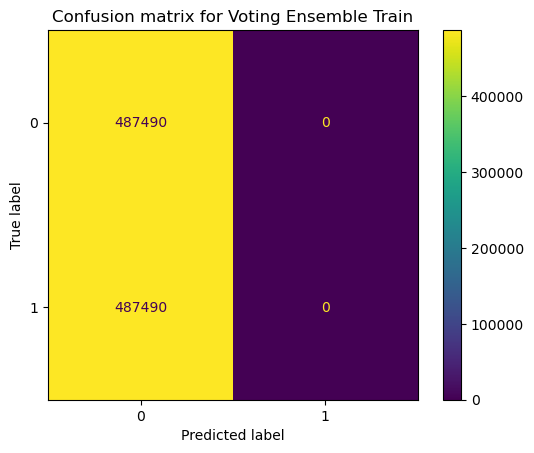

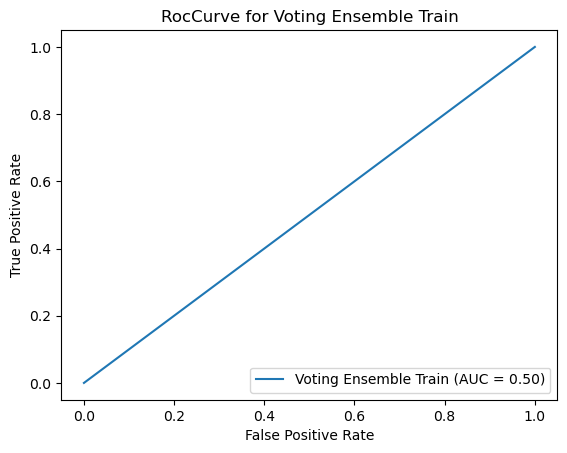

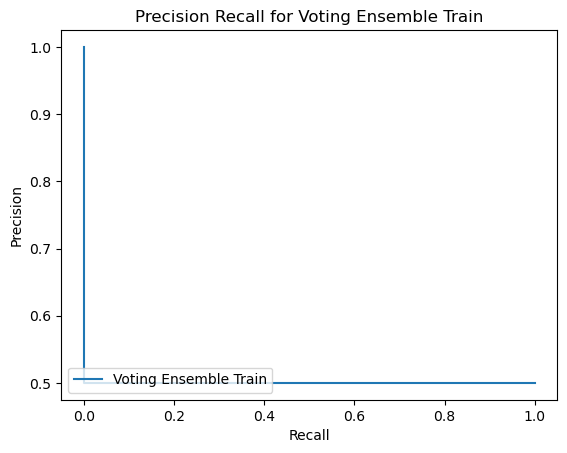

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67    487490
         1.0       0.00      0.00      0.00    487490

    accuracy                           0.50    974980
   macro avg       0.25      0.50      0.33    974980
weighted avg       0.25      0.50      0.33    974980



,Set type,AUC,F1,Accuracy,Precision,Recall
0,Train,0.5,0.0,0.5,0.0,0.0


In [258]:
train_results = evaluate_sets(ytrain_samp, y_train_pred, y_train_proba, 
                              'Train', 'Voting Ensemble Train')

train_results

# Testing

In [259]:
y_test_pred = final_model.predict(xtest_preprocessed)

y_test_proba = final_model.predict_proba(xtest_preprocessed)[:, 1]

Starting evaluation.....


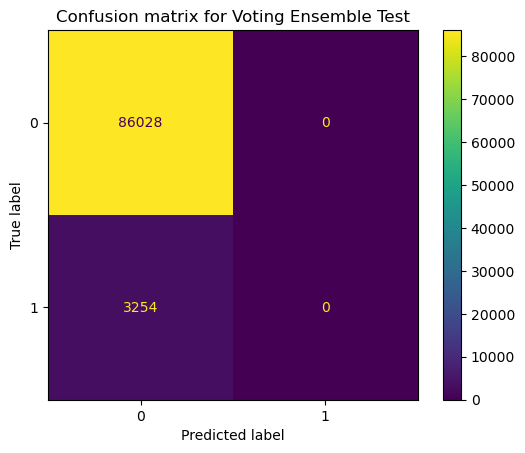

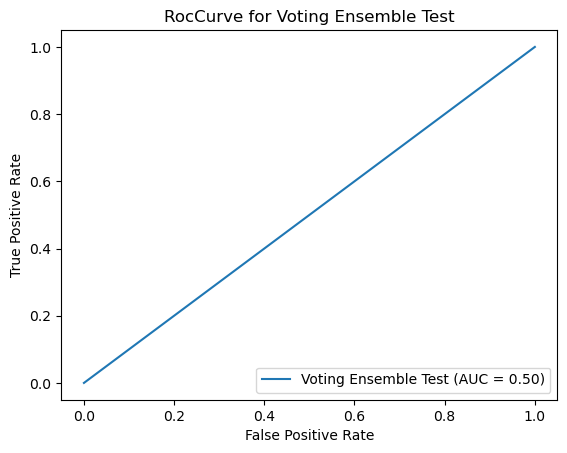

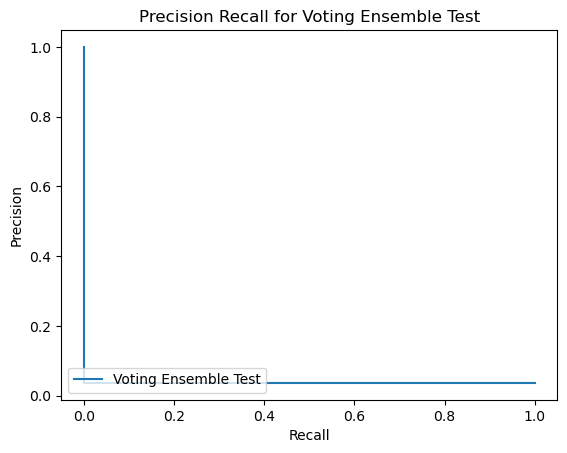

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     86028
         1.0       0.00      0.00      0.00      3254

    accuracy                           0.96     89282
   macro avg       0.48      0.50      0.49     89282
weighted avg       0.93      0.96      0.95     89282



,Set type,AUC,F1,Accuracy,Precision,Recall
0,Test,0.5,0.0,0.963554,0.0,0.0


In [260]:
test_results = evaluate_sets(ytest, y_test_pred, y_test_proba, 
                             'Test', 'Voting Ensemble Test')

test_results

# Save to config

In [266]:
# Serializing json
json_object = json.dumps(config, indent=4)
 
# Writing to sample.json
with open("C:/Users/Oamen/OneDrive/Documents/DATA PROJECTS/Insurance_claim_prediction_porto/config.json", "w") as outfile:
    outfile.write(json_object)